# Lecture 7 - Quantum Sensing and Networking

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
import qiskit.visualization as qv
import datetime as dt

import matplotlib.pyplot as plt

from qiskit.transpiler import generate_preset_pass_manager

In [4]:
# Setup the usual backend
service = QiskitRuntimeService()
backend = service.backend('ibm_rensselaer')

simulator = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
sampler = Sampler(mode=backend)

## Quantum Sensing
In quantum sensing, the general idea is to place qubits in an environment where some external field or process will cause their state to change proportionally to the strength of the field. For example, changes in temperature might decrease the length of $T_1$, so the relative number of 0's and 1's we measure will be proportional to the temperature. In the example below we define a function that takes the readout from the quantum circuit and plots the relative frequency of the number of '1's that appear in the measured bitstring.

In [5]:
def bit_counts_to_Lz(counts):
    """transform bitstring counts to collective counts.

    Args:
        counts: a dict whose keys are the observed integers for the spin
                and whose values is the number of observations

    Returns:
        counts: a dict whose keys are the observed integers for the total observed numbers of up
                and whose values is the number of observations
    """
    lz_counts = {}
    for bitstring, count in counts.items():
        measured_label = bitstring.count("1")
        if str(measured_label) in lz_counts:
            lz_counts[str(measured_label)] += count
        else:
            lz_counts[str(measured_label)] = count

    return lz_counts

Consider a situation where we have 5 qubits, all representing individual sensor elements that are located in close proximity to each other. We place them into individual superpositions and measure them. We then tally the relative numbers of "1's that we see in the readout. These are normally distributed.

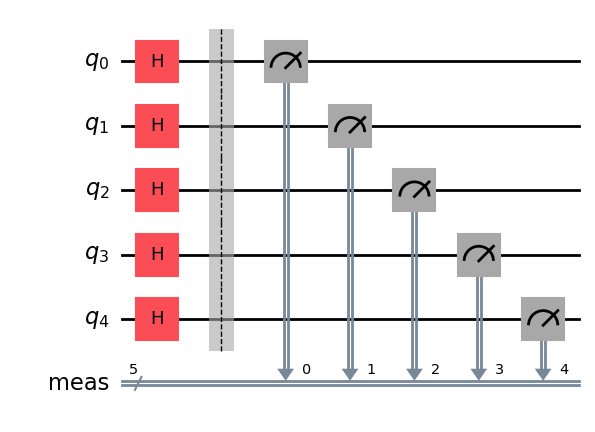

In [7]:
circuit = QuantumCircuit(5)

# initialization to create a 50 - 50 superposition
circuit.h([0,1,2,3,4])

# measurement
circuit.measure_all()
circuit.draw("mpl")

In [72]:
isa_circuit = pm.run(circuit)

job = sampler.run([isa_circuit])

In [73]:
result = job.result()

In [74]:
counts = result[0].data.meas.get_counts()

hist = bit_counts_to_Lz(counts)

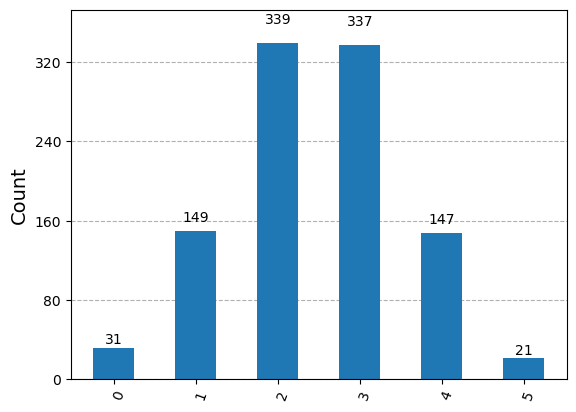

In [75]:
qv.plot_histogram(hist)

## Squeezing
Squeezing lets us use entanglement to "squeeze" more sensitivity into our measurement at the expense of greater uncertainty in other areas of the measurement. The circuit below tries to focus all the information onto qubit 2, which will amplify the counts in its measurement. If any one qubit detects a signal, it delegates all of its information to qubit 2, which collects and tallies that information from the entire sensor network.

This has the result of making us more sensitive to changes in the entire system, but at the expense of knowing the exact location of the change. It would be like having an alarm system that is extremely sensitive to an intruder in a building, but uncertain as to which room they were in. Depending on your design requirements, this tradeoff may present a net advantage.

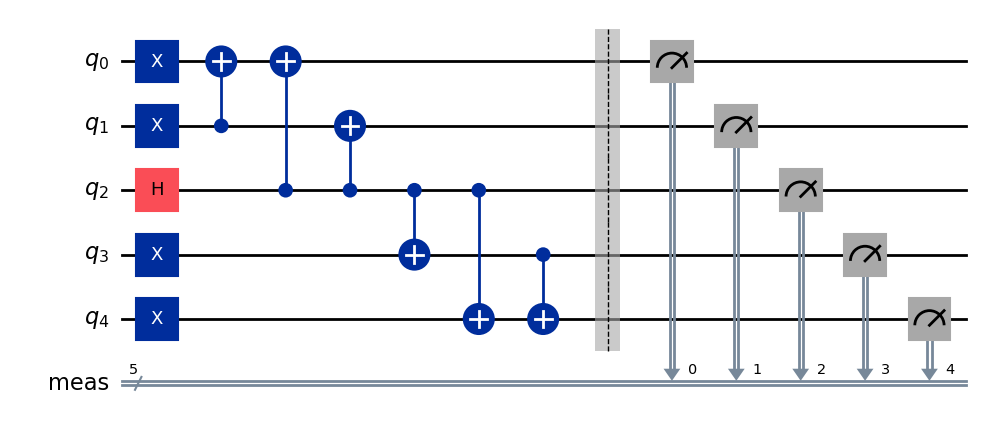

In [150]:
circuit = QuantumCircuit(5)

# initialization to create a 50 - 50 superposition
circuit.h([2])
circuit.x([0,1,3,4])
circuit.cx(1, 0)
circuit.cx(2, 0)
circuit.cx(2, 1)
circuit.cx(2, 3)
circuit.cx(2, 4)
circuit.cx(3, 4)


# measurement
circuit.measure_all()
circuit.draw("mpl")

In [116]:
isa_circuit = pm.run(circuit)

job = sampler.run([isa_circuit])

In [117]:
result = job.result()

In [118]:
counts = result[0].data.meas.get_counts()

hist = bit_counts_to_Lz(counts)

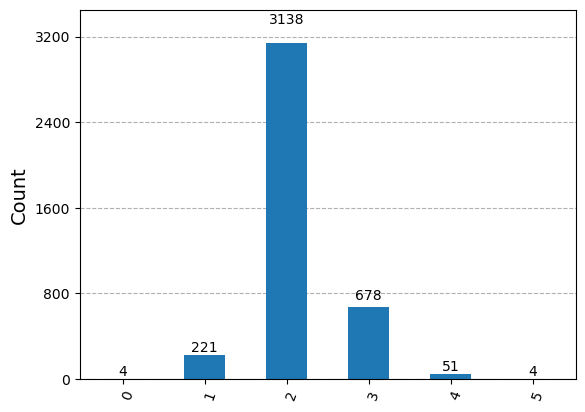

In [119]:
qv.plot_histogram(hist)

In a noise-free world, the above plot would show 100% of the counts landing on 2. Even with a noisy set of qubits, we can show an increase in the sensitivity of detecting an event in the system with squeezing.

## Teleportation

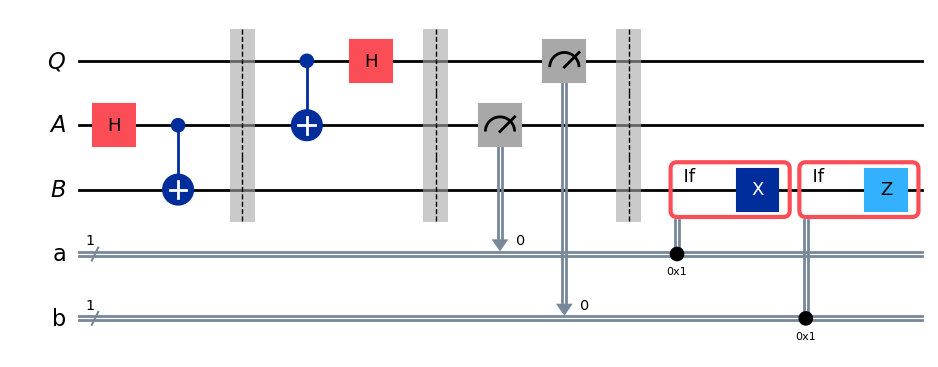

In [130]:
qubit = qs.QuantumRegister(1, "Q")
ebit0 = qs.QuantumRegister(1, "A")
ebit1 = qs.QuantumRegister(1, "B")
a = qs.ClassicalRegister(1, "a")
b = qs.ClassicalRegister(1, "b")

protocol = qs.QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw('mpl')

Since teleportation is supposed to perfectly preserve the inforation we're sending, it should be equivalent to the identity operation. We an show this by starting with an arbitrary state, teleporting, and then decoding from that arbitrary state upon arrival.

In [136]:
random_gate = qs.circuit.library.UGate(
    theta=np.random.random() * 2 * np.pi,
    phi=np.random.random() * 2 * np.pi,
    lam=np.random.random() * 2 * np.pi,
)

display(random_gate.to_matrix())

array([[0.97241347+0.j        , 0.12663762+0.19589527j],
       [0.13390139+0.19100383j, 0.3656429 -0.90105118j]])

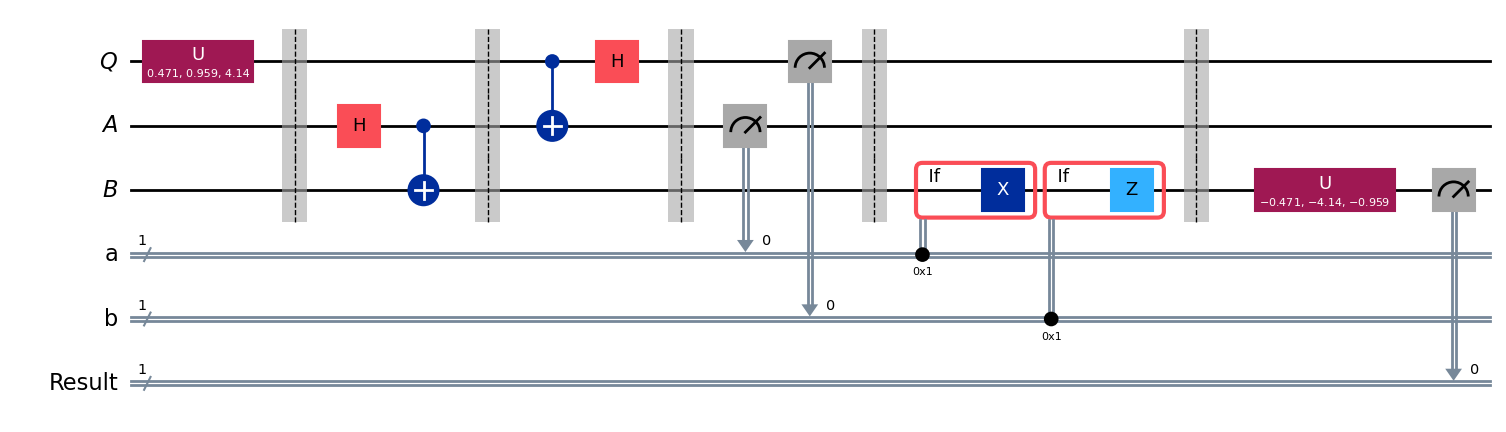

In [139]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = qs.QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)

result = qs.ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

test.draw('mpl')

In [141]:
teleport_sampler = ibm.SamplerV2(mode=simulator)

isa_qc = pm.run(test)

job = teleport_sampler.run([isa_qc])

In [142]:
result = job.result()

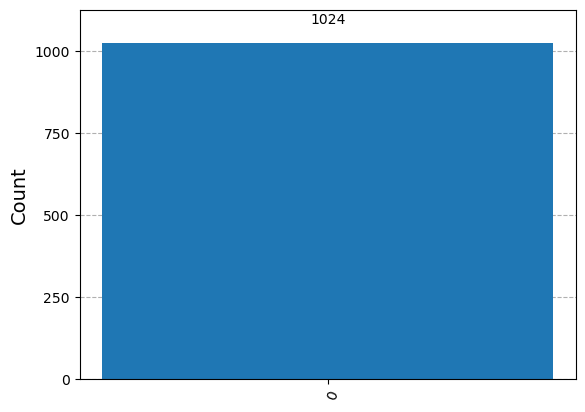

In [146]:
counts = result[0].data.Result.get_counts()

qv.plot_histogram(counts)